In [1]:
import glob
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
car_images = glob.glob("./vehicles/**/*.png")
noncar_images = glob.glob("./non-vehicles/**/*.png")

In [3]:
len(car_images),len(noncar_images)

(8792, 8968)

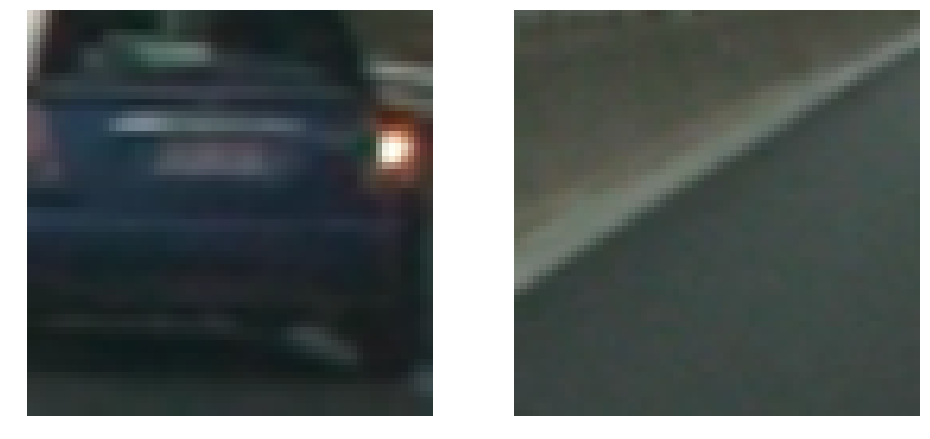

In [4]:
car_example = cv2.cvtColor(cv2.imread(car_images[1]),cv2.COLOR_BGR2RGB)
noncar_example = cv2.cvtColor(cv2.imread(noncar_images[1]),cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.axis("off")
plt.imshow(car_example)

plt.subplot(122)
plt.axis("off")
plt.imshow(noncar_example)

In [5]:
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    if vis == True:
        features,hog_image = hog(img,orientations=orient,
                                pixels_per_cell=(pix_per_cell,pix_per_cell),
                                cells_per_block=(cell_per_block,cell_per_block),
                                transform_sqrt=True,
                                visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    
    else:
        features = hog(img,orientations=orient,
                      pixels_per_cell=(pix_per_cell,pix_per_cell),
                      cells_per_block=(cell_per_block,cell_per_block),
                      transform_sqrt=True,
                      visualise=vis,feature_vector=feature_vec)
        return features

/Users/nishiharaseiakira/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


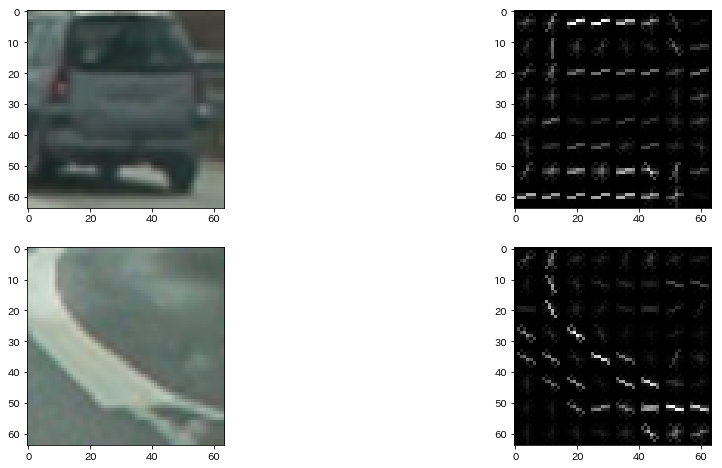

In [6]:
car_img = mpimg.imread(car_images[3])
_,car_dst = get_hog_features(car_img[:,:,2],9,8,8,vis=True,feature_vec=True)
noncar_img = mpimg.imread(noncar_images[3])
_,noncar_dst = get_hog_features(noncar_img[:,:,2],9,8,8,vis=True,feature_vec=True)

plt.figure(figsize=(16,8))

plt.subplot(221)
plt.imshow(car_img)

plt.subplot(222)
plt.imshow(car_dst,cmap="gray")

plt.subplot(223)
plt.imshow(noncar_img)

plt.subplot(224)
plt.imshow(noncar_dst,cmap="gray")

In [7]:
def extract_features(imgs,cspace="RGB",spatial_size=(32,32),hist_bins=32,orient=9, 
                     pix_per_cell=8,cell_per_block=2,hog_channel="ALL",spatial_feat=True,hist_feat=True,hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image,size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat is True:
            hist_features = color_hist(feature_image,nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat is True:
            if hog_channel == "ALL":
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                        orient,pix_per_cell,cell_per_block,
                                                        vis=False,feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,
                                               pix_per_cell,cell_per_block,vis=False,feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

In [8]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img,nbins=32):
    channel1_hist = np.histogram(img[:,:,0],bins=nbins)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins)
    
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    
    return hist_features

In [9]:
colorspace = "YCrCb"
orient = 9
hist_bins=32
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
spatial_feat = True
hist_feat = True
hog_feat = True
spatial_size=(32,32)

car_features = extract_features(car_images,cspace=colorspace,spatial_size=spatial_size, hist_bins=hist_bins,orient=orient,
                                                pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                               spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)
noncar_features = extract_features(noncar_images,cspace=colorspace,spatial_size=spatial_size,hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                                spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat)

X = np.vstack((car_features,noncar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)),np.zeros(len(noncar_features))))


/Users/nishiharaseiakira/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [10]:
len(X)

17760

In [11]:
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=123)

In [12]:
X_train.shape,y_train.shape

((14208, 8460), (14208,))

In [13]:
svc = LinearSVC()
svc.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [14]:
svc.predict(X_test[0:10])

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.])

In [15]:
def draw_boxes(img,bboxes,color=(0,0,255),thick=6):
    imcopy = np.copy(img)
    
    for bbox in bboes:
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

def slide_window(img,x_start_stop=[None,None],y_start_stop = [None,None],
                           xy_window=(64,64),xy_overloap=(0.5,0.5)):
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overloap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overloap[1]))
    
    nx_buffer = np.int(xy_window[0] * (xy_overloap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overloap[1]))
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer)/ny_pix_per_step)
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx   = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy  = starty + xy_window[1]
            
            window_list.append(((startx,starty),(endx,endy)))
            
    return window_list

In [16]:
def convert_color(img,conv="RGB2YCrCb"):
    if conv == "RGB2YCrCb":
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    if conv == "BGR2YCrCb":
        return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
    if conv == "RGB2LUV":
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV)

In [17]:
def find_cars(img,ystart=400,ystop=656,scale=1.5,svc=svc,X_scaler=X_scaler,color_space='YCrCb', orient=9, pix_per_cell=8,cell_per_block=2,
              hog_channel="ALL",spatial_size=(32,32),hist_bins=32):
    
    box_list = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch,conv="RGB2" + color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch =  cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) -1
    nyblocks = (ch1.shape[0] // pix_per_cell) -1
    nfeat_per_block = orient * cell_per_block ** 2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,feature_vec=False)
    if hog_channel == "ALL":
        hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,feature_vec=False)
        hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            if hog_channel == "ALL":
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            else:
                hog_features = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
                
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window],(64,64))
            
            spatial_features = bin_spatial(subimg,size=spatial_size)
            hist_features = color_hist(subimg,nbins=hist_bins)
            
            test_features  = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img,(xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                box_list.append(((xbox_left,ytop_draw + ystart),(xbox_left + win_draw,ytop_draw + win_draw + ystart)))
    return draw_img,box_list




In [24]:
test_img = mpimg.imread("./test_images/test1.jpg")
ystart = 400
ystop = 656
scale = 1.5
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32,32)
hist_bins=32
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

out_img,box_list= find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

/Users/nishiharaseiakira/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


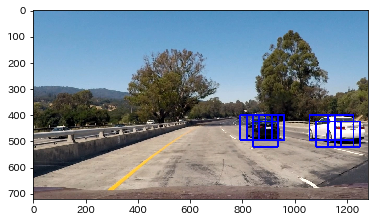

In [25]:
plt.imshow(out_img)

In [26]:
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
        
    return heatmap

def apply_threshold(heatmap,threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img,labels):
    for car_number in range(1,labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        
        cv2.rectangle(img,bbox[0],bbox[1],(0,0,255),6)
        
    return img


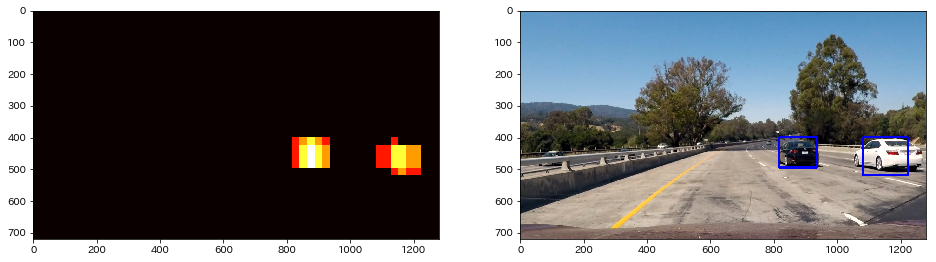

In [28]:
from scipy.ndimage.measurements import label
heat = np.zeros_like(test_img[:,:,0]).astype(np.float64)
heat = add_heat(heat,box_list)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat,0,255)
labels = label(heatmap)
heatimg = draw_labeled_bboxes(np.copy(test_img),labels)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(heatmap,cmap="hot")
plt.subplot(122)
plt.imshow(heatimg,cmap="hot")

In [33]:
def process_frame(img):

    rectangles = []

    colorspace = 'YCrCb' 
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' 

    ystart = 400
    ystop = 464
    scale = 1.0
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)
    ystart = 416
    ystop = 480
    scale = 1.0
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)
    
    ystart = 400
    ystop = 496
    scale = 1.5
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)
    
    ystart = 432
    ystop = 528
    scale = 1.5
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)
    
    ystart = 400
    ystop = 528
    scale = 2.0
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)
    
    ystart = 432
    ystop = 560
    scale = 2.0
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)
    
    ystart = 400
    ystop = 596
    scale = 3.5
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)
    
    ystart = 464
    ystop = 660
    scale = 3.5
    _,temp_rectangles = find_cars(img)
    rectangles.append(temp_rectangles)

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


/Users/nishiharaseiakira/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


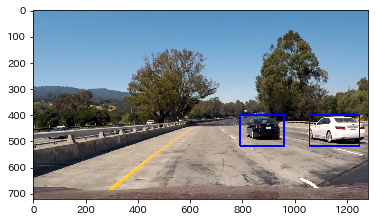

In [34]:
test_img = mpimg.imread("./test_images/test1.jpg")
out_img = process_frame(test_img)
plt.imshow(out_img)

/Users/nishiharaseiakira/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


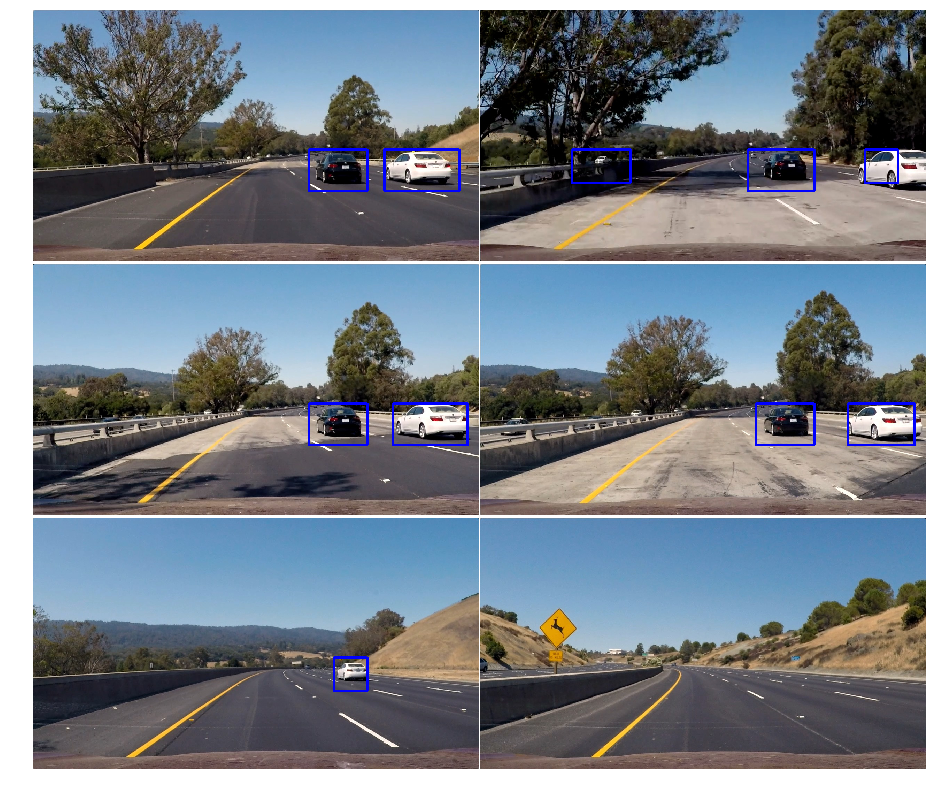

In [35]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [54]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:59<00:03,  3.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 56s, sys: 3.53 s, total: 1min 59s
Wall time: 2min


In [56]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [58]:
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [1:13:27<00:03,  3.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 9min 3s, sys: 2min 1s, total: 1h 11min 5s
Wall time: 1h 13min 28s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))